In [7]:
using Pkg

# Activate local project environment
Pkg.activate(expanduser("/g/data/v46/txs156/ocean-ensembles/"))

# Add the global environment to the package search path
push!(LOAD_PATH, expanduser("/g/data/e14/txs156/.julia/environments/v1.10/"))

# Pkg.precompile()

using CairoMakie, IJulia, JLD2  # From global
using Oceananigans  # From local
using Statistics

  Activating project at `/g/data/v46/txs156/ocean-ensembles`
Precompiling packages...
    626.7 ms  ✓ SeawaterPolynomials
   1351.0 ms  ✓ ExpressionExplorer
    624.2 ms  ✓ ReactantCore
  17290.2 ms  ✓ GPUCompiler
  60382.9 ms  ✓ CUDA
   6266.4 ms  ✓ Atomix → AtomixCUDAExt
   5928.7 ms  ✓ MPI → CUDAExt
  23683.8 ms  ✓ Oceananigans
  8 dependencies successfully precompiled in 121 seconds. 121 already precompiled.
Precompiling packages...
   5458.6 ms  ✓ CUDA → SpecialFunctionsExt
   5481.4 ms  ✓ ArrayInterface → ArrayInterfaceCUDAExt
  2 dependencies successfully precompiled in 7 seconds. 109 already precompiled.
Precompiling packages...
   5459.1 ms  ✓ CUDA → ChainRulesCoreExt
  1 dependency successfully precompiled in 6 seconds. 76 already precompiled.
[ Info: Oceananigans will use 48 threads
Precompiling packages...
  11945.5 ms  ✓ Oceananigans → OceananigansMakieExt
  1 dependency successfully precompiled in 19 seconds. 317 already precompiled.


In [8]:
experiment_path = expanduser("/g/data/v46/txs156/ocean-ensembles/")

"/g/data/v46/txs156/ocean-ensembles/"

In [35]:
variables_basins = ["_global", "_atlantic", "_pacific"]
variables_tracers = ["T", "S", "u", "v", "w", "dV"]

variables = [tracer * basin for tracer in variables_tracers, basin in variables_basins]
variables = vec(variables)  # Flatten into a 1D list

function load_timeseries(vars, path)
    vals = Dict()
    for var in vars
        try
            # Surface
            vals[var] = FieldTimeSeries(path, var)
        catch e
            if e isa KeyError
                @warn "Skipping variable $var: Key not found in file."
            else
                rethrow(e)
            end
        end
    end
    return vals
end

surface_props = load_timeseries(variables_tracers, "/g/data/v46/txs156/ocean-ensembles/" * "global_surface_fields_new.jld2")
int_za = load_timeseries(variables, "/g/data/v46/txs156/ocean-ensembles/" * "zonally_integrated_data_new.jld2")

┌ Warning: Skipping variable dV: Key not found in file.
└ @ Main In[35]:15


Dict{Any, Any} with 18 entries:
  "u_atlantic"  => 1×180×100×334 FieldTimeSeries{InMemory} located at (⋅, Cente…
  "S_pacific"   => 1×180×100×334 FieldTimeSeries{InMemory} located at (⋅, Cente…
  "u_pacific"   => 1×180×100×334 FieldTimeSeries{InMemory} located at (⋅, Cente…
  "w_pacific"   => 1×180×101×334 FieldTimeSeries{InMemory} located at (⋅, Cente…
  "w_atlantic"  => 1×180×101×334 FieldTimeSeries{InMemory} located at (⋅, Cente…
  "dV_global"   => 1×180×100×334 FieldTimeSeries{InMemory} located at (⋅, Cente…
  "dV_atlantic" => 1×180×100×334 FieldTimeSeries{InMemory} located at (⋅, Cente…
  "v_pacific"   => 1×180×100×334 FieldTimeSeries{InMemory} located at (⋅, Face,…
  "S_atlantic"  => 1×180×100×334 FieldTimeSeries{InMemory} located at (⋅, Cente…
  "T_global"    => 1×180×100×334 FieldTimeSeries{InMemory} located at (⋅, Cente…
  "w_global"    => 1×180×101×334 FieldTimeSeries{InMemory} located at (⋅, Cente…
  "v_global"    => 1×180×100×334 FieldTimeSeries{InMemory} located at (⋅, Fac

## Surface Analysis

(334,)


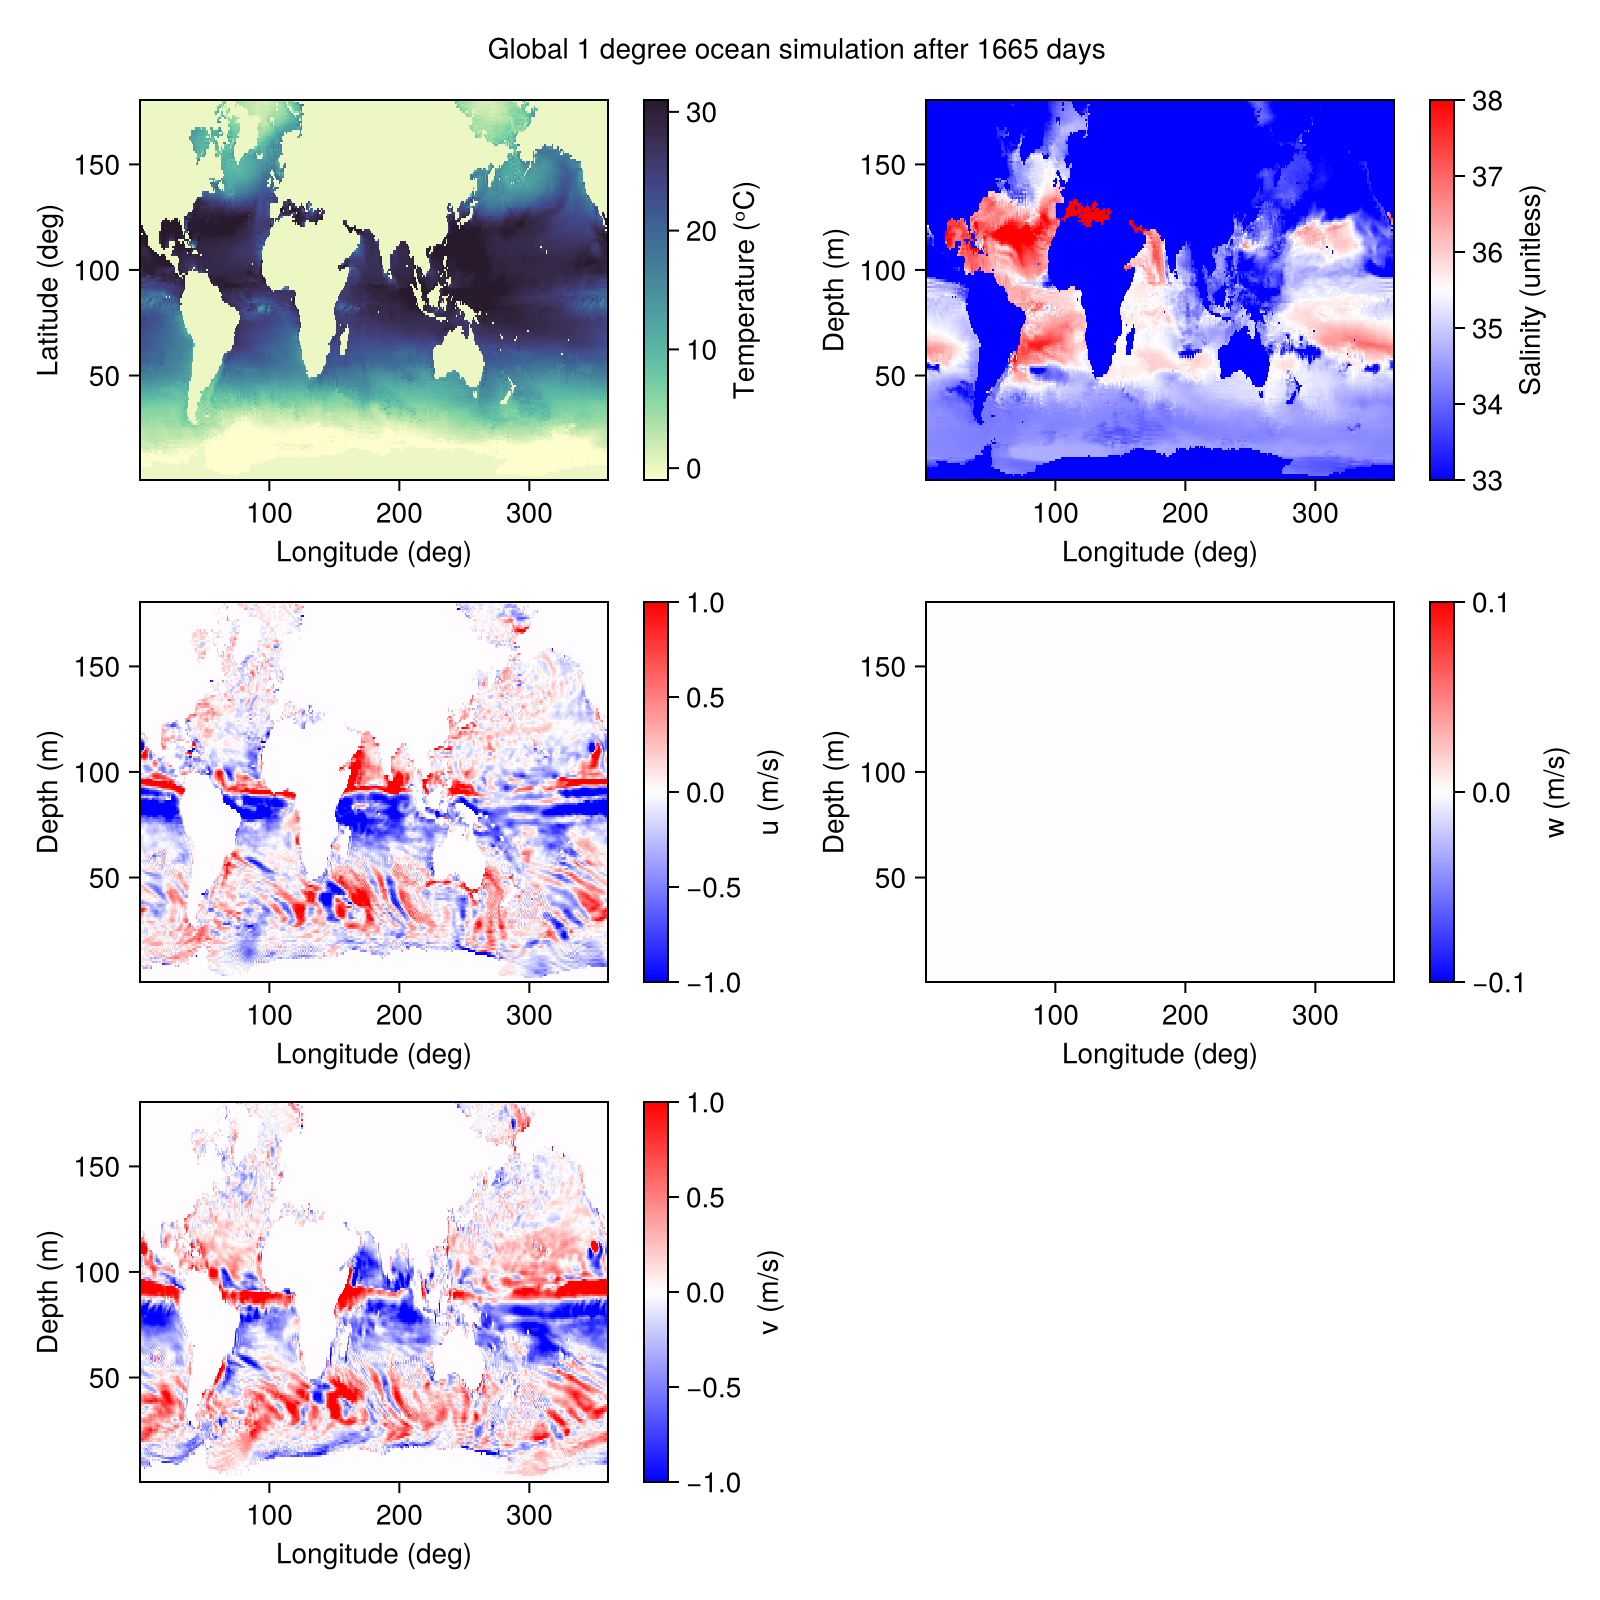

CairoMakie.Screen{IMAGE}


In [38]:
fig = Figure(size = (800, 800))
# axs = Axis(fig[1, 1], xlabel="Longitude (deg)", ylabel="Latitude (deg)")

time_slice = 334

times = surface_props["T"].times
println(size(times))
title = string("Global 1 degree ocean simulation after ",
                         prettytime(times[time_slice] - times[1]))

axs = Axis(fig[1, 1], xlabel="Longitude (deg)", ylabel="Latitude (deg)")
hm = heatmap!(axs, view(interior(surface_props["T"][time_slice]), :, :, 1), colorrange = (-1,31), colormap = :deep, nan_color=:lightgray)
Colorbar(fig[1, 2], hm, label = "Temperature (ᵒC)")

axs = Axis(fig[2, 1], xlabel="Longitude (deg)", ylabel="Depth (m)")
hm = heatmap!(axs, view(interior(surface_props["u"][time_slice]), :, :, 1) , colorrange = (-1,1), colormap = :bwr, nan_color=:lightgray)
Colorbar(fig[2, 2], hm, label = "u (m/s)")

axs = Axis(fig[3, 1], xlabel="Longitude (deg)", ylabel="Depth (m)")
hm = heatmap!(axs, view(interior(surface_props["v"][time_slice]), :, :, 1) , colorrange = (-1,1), colormap = :bwr, nan_color=:lightgray)
Colorbar(fig[3, 2], hm, label = "v (m/s)")

axs = Axis(fig[2, 3], xlabel="Longitude (deg)", ylabel="Depth (m)")
hm = heatmap!(axs, view(interior(surface_props["w"][time_slice]), :, :, 1), colorrange = (-.1,.1), colormap = :bwr, nan_color=:lightgray)
Colorbar(fig[2, 4], hm, label = "w (m/s)")

axs = Axis(fig[1, 3], xlabel="Longitude (deg)", ylabel="Depth (m)")
hm = heatmap!(axs, view(interior(surface_props["S"][time_slice]), :, :, 1) , colorrange = (33, 38), colormap = :bwr, nan_color=:lightgray)
Colorbar(fig[1, 4], hm, label = "Salinity (unitless)")

Label(fig[0, :], title)

display(fig)


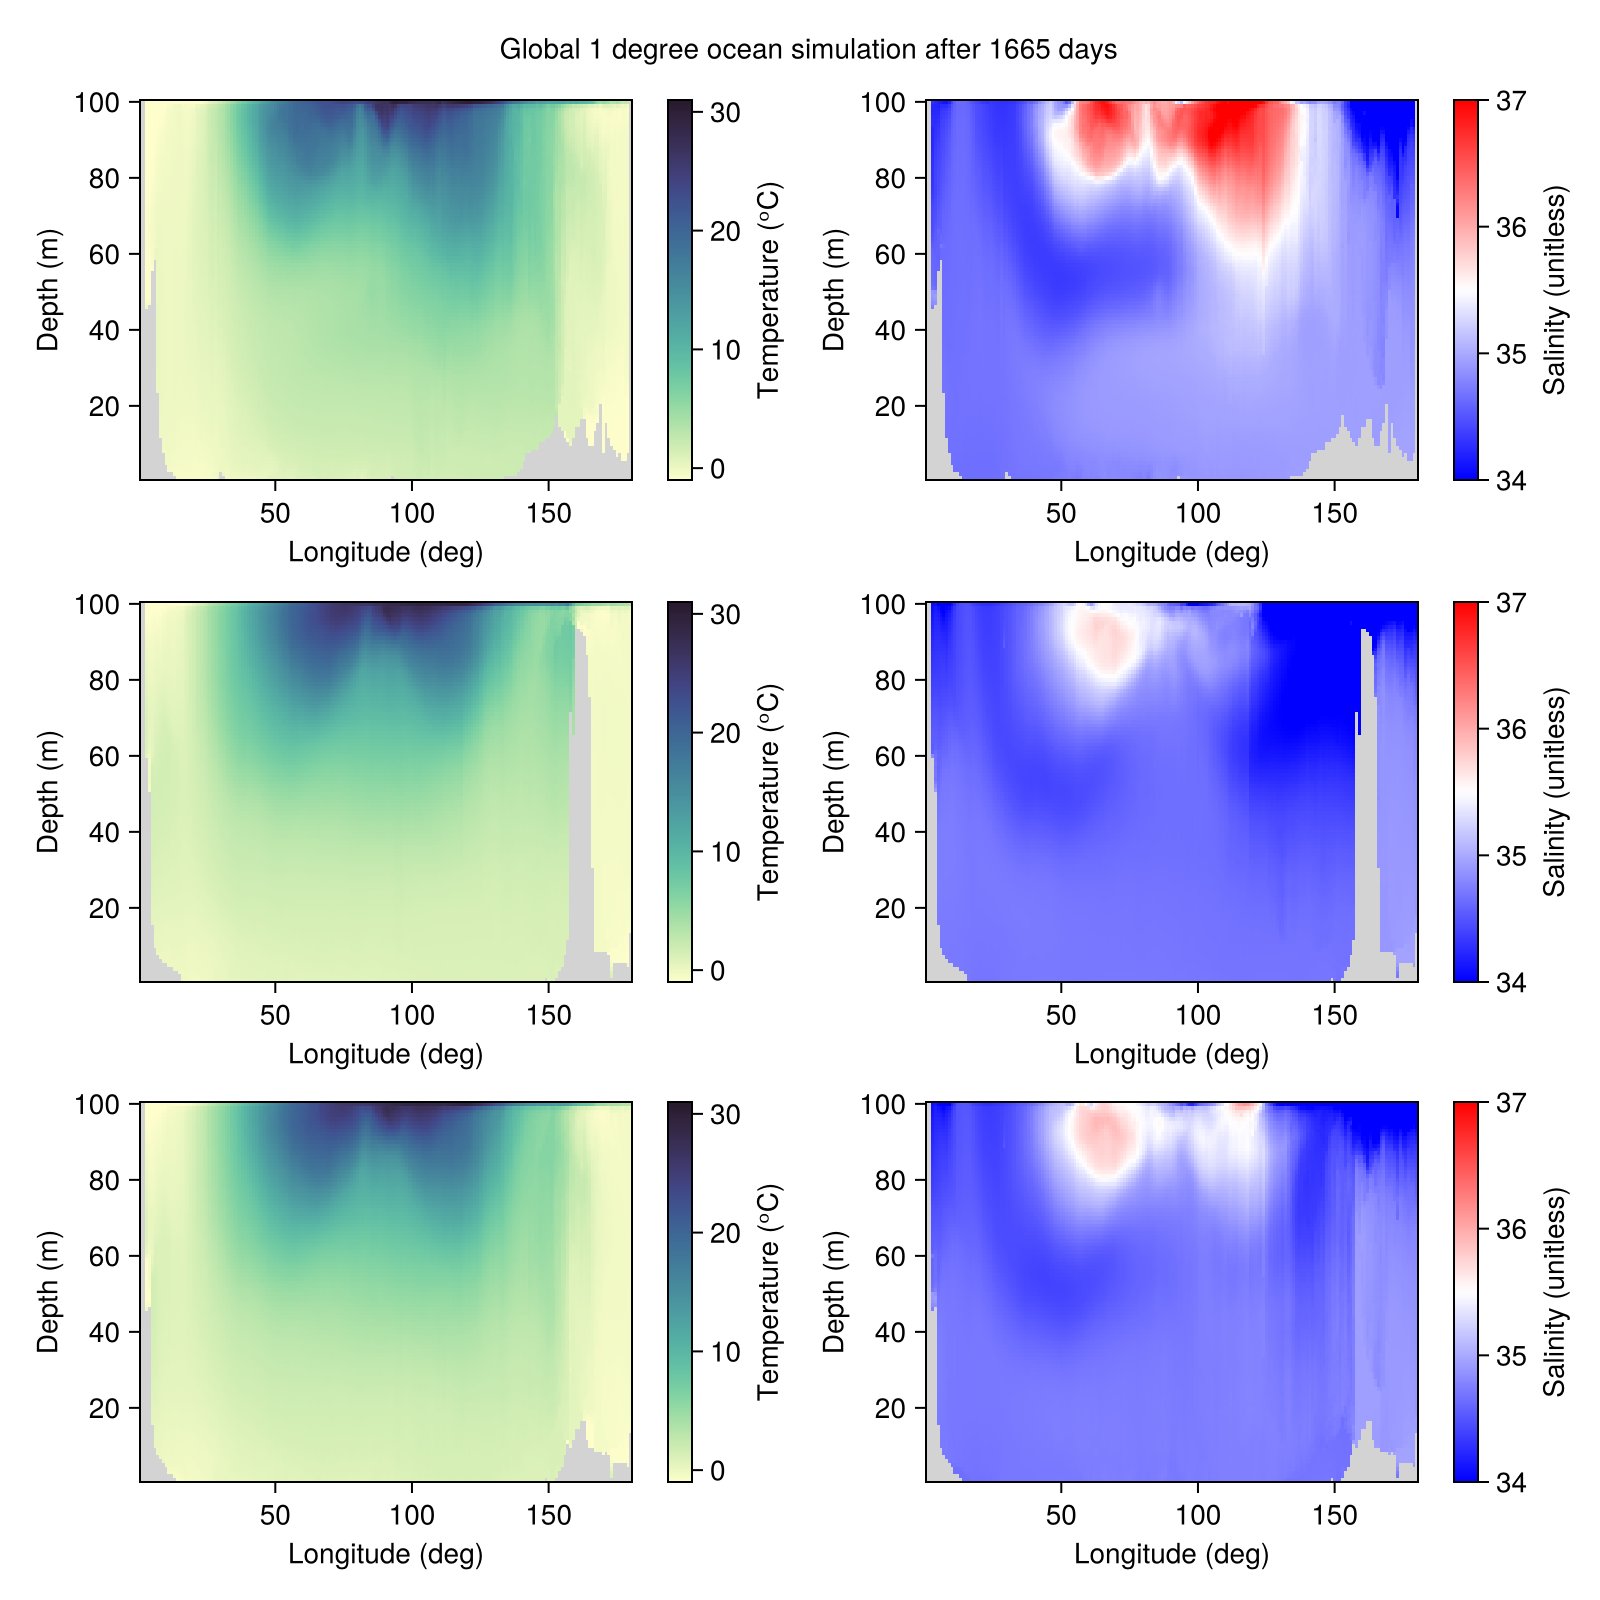

CairoMakie.Screen{IMAGE}


In [39]:
fig = Figure(size = (800, 800))
# axs = Axis(fig[1, 1], xlabel="Longitude (deg)", ylabel="Latitude (deg)")

time_slice = 334

times = int_za["S_atlantic"].times

S_avg_atl = view(interior(int_za["S_atlantic"][time_slice]/int_za["dV_atlantic"][time_slice]), 1, :, :)
S_avg_ipac = view(interior(int_za["S_pacific"][time_slice]/int_za["dV_pacific"][time_slice]), 1, :, :)
S_avg_glob = view(interior(int_za["S_global"][time_slice]/int_za["dV_global"][time_slice]), 1, :, :)
T_avg_atl = view(interior(int_za["T_atlantic"][time_slice]/int_za["dV_atlantic"][time_slice]), 1, :, :)
T_avg_ipac = view(interior(int_za["T_pacific"][time_slice]/int_za["dV_pacific"][time_slice]), 1, :, :)
T_avg_glob = view(interior(int_za["T_global"][time_slice]/int_za["dV_global"][time_slice]), 1, :, :)

title = string("Global 1 degree ocean simulation after ",
                         prettytime(times[time_slice] - times[1]))

axs = Axis(fig[1, 1], xlabel="Longitude (deg)", ylabel="Depth (m)")
hm = heatmap!(axs, T_avg_atl, colorrange = (-1,31), colormap = :deep, nan_color=:lightgray)
Colorbar(fig[1, 2], hm, label = "Temperature (ᵒC)")

axs = Axis(fig[2, 1], xlabel="Longitude (deg)", ylabel="Depth (m)")
hm = heatmap!(axs, T_avg_ipac , colorrange = (-1,31), colormap = :deep, nan_color=:lightgray)
Colorbar(fig[2, 2], hm, label = "Temperature (ᵒC)")

axs = Axis(fig[3, 1], xlabel="Longitude (deg)", ylabel="Depth (m)")
hm = heatmap!(axs, T_avg_glob , colorrange = (-1,31), colormap = :deep, nan_color=:lightgray)
Colorbar(fig[3, 2], hm, label = "Temperature (ᵒC)")

axs = Axis(fig[1, 3], xlabel="Longitude (deg)", ylabel="Depth (m)")
hm = heatmap!(axs, S_avg_atl, colorrange = (34, 37), colormap = :bwr, nan_color=:lightgray)
Colorbar(fig[1, 4], hm, label = "Salinity (unitless)")

axs = Axis(fig[2, 3], xlabel="Longitude (deg)", ylabel="Depth (m)")
hm = heatmap!(axs, S_avg_ipac , colorrange = (34, 37), colormap = :bwr, nan_color=:lightgray)
Colorbar(fig[2, 4], hm, label = "Salinity (unitless)")

axs = Axis(fig[3, 3], xlabel="Longitude (deg)", ylabel="Depth (m)")
hm = heatmap!(axs, S_avg_glob , colorrange = (34, 37), colormap = :bwr, nan_color=:lightgray)
Colorbar(fig[3, 4], hm, label = "Salinity (unitless)")

Label(fig[0, :], title)

display(fig)

## Zonal analysis

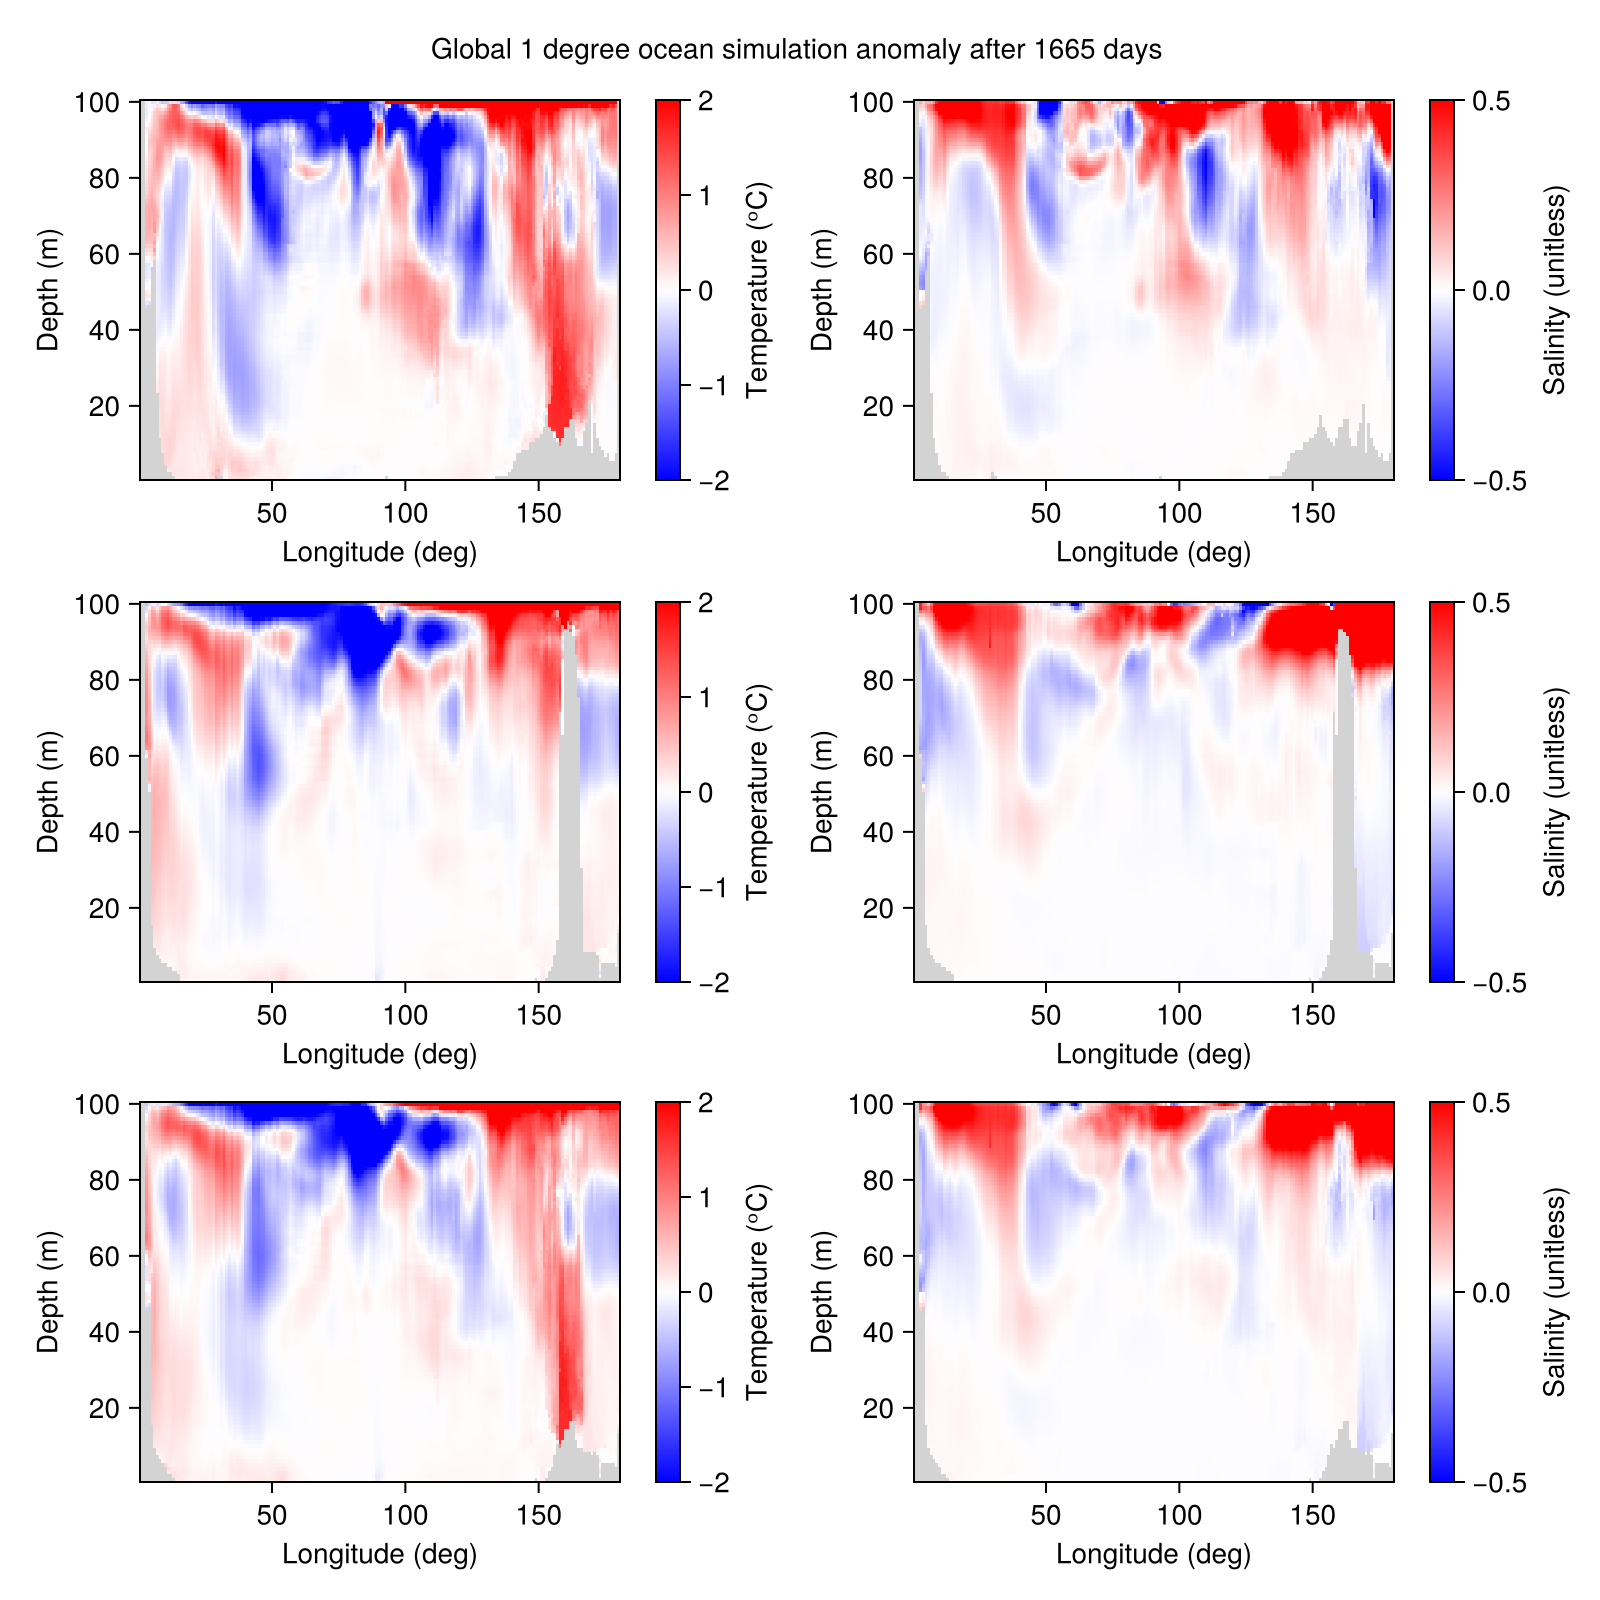

CairoMakie.Screen{IMAGE}


In [12]:
fig = Figure(size = (800, 800))
# axs = Axis(fig[1, 1], xlabel="Longitude (deg)", ylabel="Latitude (deg)")

time_slice = 1

times = int_za["S_atlantic"].times

S_avg_atl_init = view(interior(int_za["S_atlantic"][time_slice]/int_za["dV_atlantic"][time_slice]), 1, :, :)
S_avg_ipac_init = view(interior(int_za["S_pacific"][time_slice]/int_za["dV_pacific"][time_slice]), 1, :, :)
S_avg_glob_init = view(interior(int_za["S_global"][time_slice]/int_za["dV_global"][time_slice]), 1, :, :)
T_avg_atl_init = view(interior(int_za["T_atlantic"][time_slice]/int_za["dV_atlantic"][time_slice]), 1, :, :)
T_avg_ipac_init = view(interior(int_za["T_pacific"][time_slice]/int_za["dV_pacific"][time_slice]), 1, :, :)
T_avg_glob_init = view(interior(int_za["T_global"][time_slice]/int_za["dV_global"][time_slice]), 1, :, :)

time_slice = 334

S_avg_atl = view(interior(int_za["S_atlantic"][time_slice]/int_za["dV_atlantic"][time_slice]), 1, :, :)
S_avg_ipac = view(interior(int_za["S_pacific"][time_slice]/int_za["dV_pacific"][time_slice]), 1, :, :)
S_avg_glob = view(interior(int_za["S_global"][time_slice]/int_za["dV_global"][time_slice]), 1, :, :)
T_avg_atl = view(interior(int_za["T_atlantic"][time_slice]/int_za["dV_atlantic"][time_slice]), 1, :, :)
T_avg_ipac = view(interior(int_za["T_pacific"][time_slice]/int_za["dV_pacific"][time_slice]), 1, :, :)
T_avg_glob = view(interior(int_za["T_global"][time_slice]/int_za["dV_global"][time_slice]), 1, :, :)

title = string("Global 1 degree ocean simulation anomaly after ",
                         prettytime(times[time_slice] - times[1]))

axs = Axis(fig[1, 1], xlabel="Longitude (deg)", ylabel="Depth (m)")
hm = heatmap!(axs, T_avg_atl - T_avg_atl_init, colorrange = (-2,2), colormap = :bwr, nan_color=:lightgray)
Colorbar(fig[1, 2], hm, label = "Temperature (ᵒC)")

axs = Axis(fig[2, 1], xlabel="Longitude (deg)", ylabel="Depth (m)")
hm = heatmap!(axs, T_avg_ipac - T_avg_ipac_init, colorrange = (-2,2), colormap = :bwr, nan_color=:lightgray)
Colorbar(fig[2, 2], hm, label = "Temperature (ᵒC)")

axs = Axis(fig[3, 1], xlabel="Longitude (deg)", ylabel="Depth (m)")
hm = heatmap!(axs, T_avg_glob - T_avg_glob_init, colorrange = (-2,2), colormap = :bwr, nan_color=:lightgray)
Colorbar(fig[3, 2], hm, label = "Temperature (ᵒC)")

axs = Axis(fig[1, 3], xlabel="Longitude (deg)", ylabel="Depth (m)")
hm = heatmap!(axs, S_avg_atl - S_avg_atl_init, colorrange = (-0.5, 0.5), colormap = :bwr, nan_color=:lightgray)
Colorbar(fig[1, 4], hm, label = "Salinity (unitless)")

axs = Axis(fig[2, 3], xlabel="Longitude (deg)", ylabel="Depth (m)")
hm = heatmap!(axs, S_avg_ipac - S_avg_ipac_init, colorrange = (-0.5, 0.5), colormap = :bwr, nan_color=:lightgray)
Colorbar(fig[2, 4], hm, label = "Salinity (unitless)")

axs = Axis(fig[3, 3], xlabel="Longitude (deg)", ylabel="Depth (m)")
hm = heatmap!(axs, S_avg_glob - S_avg_glob_init, colorrange = (-0.5, 0.5), colormap = :bwr, nan_color=:lightgray)
Colorbar(fig[3, 4], hm, label = "Salinity (unitless)")

Label(fig[0, :], title)

display(fig)

## Global

In [42]:
int_za["T_global"][1]

1×180×100 Field{Nothing, Center, Center} reduced over dims = (1,) on ImmersedBoundaryGrid on CPU
├── grid: 360×180×100 ImmersedBoundaryGrid{Float64, Periodic, Oceananigans.Grids.RightConnected, Bounded} on CPU with 5×5×4 halo
├── boundary conditions: FieldBoundaryConditions
│   └── west: Nothing, east: Nothing, south: ZeroFlux, north: Zipper, bottom: ZeroFlux, top: ZeroFlux, immersed: Default
└── data: 1×190×108 OffsetArray(view(::Array{Float64, 4}, :, :, :, 1), 1:1, -4:185, -3:104) with eltype Float64 with indices 1:1×-4:185×-3:104
    └── max=8.70096e8, min=-1.61463e7, mean=1.18362e8

In [32]:
using Oceananigans.Operators: Δyᵃᶜᵃ

In [41]:
compute!(Field(Integral(int_za["T_global"][1], dims = (2,3))))

1×1×1 Field{Nothing, Nothing, Nothing} reduced over dims = (1, 2, 3) on ImmersedBoundaryGrid on CPU
├── data: OffsetArrays.OffsetArray{Float64, 3, Array{Float64, 3}}, size: (1, 1, 1)
├── grid: 360×180×100 ImmersedBoundaryGrid{Float64, Periodic, Oceananigans.Grids.RightConnected, Bounded} on CPU with 5×5×4 halo
├── operand: Integral of ConditionalOperation of BinaryOperation at (⋅, Center, Center) with condition (::Oceananigans.ImmersedBoundaries.NotImmersedColumn{Field{Nothing, Center, Center, Nothing, ImmersedBoundaryGrid{Float64, Periodic, Oceananigans.Grids.RightConnected, Bounded, OrthogonalSphericalShellGrid{Float64, Periodic, Oceananigans.Grids.RightConnected, Bounded, Oceananigans.Grids.MutableVerticalDiscretization{OffsetArrays.OffsetVector{Float64, Vector{Float64}}, OffsetArrays.OffsetVector{Float64, Vector{Float64}}, OffsetArrays.OffsetVector{Float64, Vector{Float64}}, OffsetArrays.OffsetVector{Float64, Vector{Float64}}, OffsetArrays.OffsetArray{Float64, 3, Array{Float64, 3}}

In [37]:
OHC_global = zeros(size(times))
for time_step in size(times)
    println(time_step)
    OHC_global[time_step] = compute!(Field(Integral(int_za["T_global"][time_step], dims = (2,3))))
end
# OHC_atl= compute!(Field(Integral(int_za["T_atlantic"], dims = (2,3))))
# OHC_pacific = compute!(Field(Integral(int_za["T_pacific"], dims = (2,3))))

LoadError: MethodError: no method matching Δyᵃᶜᵃ(::Int64, ::Int64, ::Int64, ::ImmersedBoundaryGrid{Float64, Periodic, Oceananigans.Grids.RightConnected, Bounded, OrthogonalSphericalShellGrid{Float64, Periodic, Oceananigans.Grids.RightConnected, Bounded, Oceananigans.Grids.MutableVerticalDiscretization{OffsetArrays.OffsetVector{Float64, Vector{Float64}}, OffsetArrays.OffsetVector{Float64, Vector{Float64}}, OffsetArrays.OffsetVector{Float64, Vector{Float64}}, OffsetArrays.OffsetVector{Float64, Vector{Float64}}, OffsetArrays.OffsetArray{Float64, 3, Array{Float64, 3}}, OffsetArrays.OffsetArray{Float64, 3, Array{Float64, 3}}, OffsetArrays.OffsetArray{Float64, 3, Array{Float64, 3}}, OffsetArrays.OffsetArray{Float64, 3, Array{Float64, 3}}, OffsetArrays.OffsetArray{Float64, 3, Array{Float64, 3}}}, Oceananigans.OrthogonalSphericalShellGrids.Tripolar{Int64, Int64, Int64}, OffsetArrays.OffsetMatrix{Float64, Matrix{Float64}}, OffsetArrays.OffsetMatrix{Float64, Matrix{Float64}}, OffsetArrays.OffsetMatrix{Float64, Matrix{Float64}}, OffsetArrays.OffsetMatrix{Float64, Matrix{Float64}}, CPU, Float64}, GridFittedBottom{Field{Center, Center, Nothing, Nothing, OrthogonalSphericalShellGrid{Float64, Periodic, Oceananigans.Grids.RightConnected, Bounded, Oceananigans.Grids.MutableVerticalDiscretization{OffsetArrays.OffsetVector{Float64, Vector{Float64}}, OffsetArrays.OffsetVector{Float64, Vector{Float64}}, OffsetArrays.OffsetVector{Float64, Vector{Float64}}, OffsetArrays.OffsetVector{Float64, Vector{Float64}}, OffsetArrays.OffsetArray{Float64, 3, Array{Float64, 3}}, OffsetArrays.OffsetArray{Float64, 3, Array{Float64, 3}}, OffsetArrays.OffsetArray{Float64, 3, Array{Float64, 3}}, OffsetArrays.OffsetArray{Float64, 3, Array{Float64, 3}}, OffsetArrays.OffsetArray{Float64, 3, Array{Float64, 3}}}, Oceananigans.OrthogonalSphericalShellGrids.Tripolar{Int64, Int64, Int64}, OffsetArrays.OffsetMatrix{Float64, Matrix{Float64}}, OffsetArrays.OffsetMatrix{Float64, Matrix{Float64}}, OffsetArrays.OffsetMatrix{Float64, Matrix{Float64}}, OffsetArrays.OffsetMatrix{Float64, Matrix{Float64}}, CPU, Float64}, Tuple{Colon, Colon, Colon}, OffsetArrays.OffsetArray{Float64, 3, Array{Float64, 3}}, Float64, FieldBoundaryConditions{BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Zipper, Int64}, Nothing, Nothing, Oceananigans.BoundaryConditions.DefaultBoundaryCondition{BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Nothing}}}, Nothing, Oceananigans.Fields.FieldBoundaryBuffers{Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing}}, Oceananigans.ImmersedBoundaries.CenterImmersedCondition}, Nothing, Nothing, CPU})

[0mClosest candidates are:
[0m  Δyᵃᶜᵃ(::Any, ::Any, ::Any, [91m::Union{ImmersedBoundaryGrid{F, X, Y, Z, <:RectilinearGrid} where {F, X, Y, Z}, ImmersedBoundaryGrid{F, X, Y, Z, <:LatitudeLongitudeGrid} where {F, X, Y, Z}}[39m)
[0m[90m   @[39m [32mOceananigans[39m [90m/g/data/e14/txs156/.julia/packages/Oceananigans/yPldL/src/ImmersedBoundaries/[39m[90m[4mimmersed_grid_metrics.jl:34[24m[39m
[0m  Δyᵃᶜᵃ(::Any, ::Any, ::Any, [91m::Oceananigans.Grids.YRegularLLG{<:Any, var"#s494", var"#s493", var"#s492", var"#s491", var"#s494", var"#s493", var"#s492", var"#s491", <:Any, <:Any, <:Any, <:Any, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing} where {var"#s494", var"#s493", var"#s492"<:Number, var"#s491"<:Number, var"#s494", var"#s493", var"#s492", var"#s491"}[39m)
[0m[90m   @[39m [32mOceananigans[39m [90m/g/data/e14/txs156/.julia/packages/Oceananigans/yPldL/src/Operators/[39m[90m[4mspacings_and_areas_and_volumes.jl:170[24m[39m
[0m  Δyᵃᶜᵃ(::Any, ::Any, ::Any, [91m::LatitudeLongitudeGrid{<:Any, <:Any, <:Any, <:Any, <:Any, DXF, DXC, <:Any, <:Any, DYF, DYC, <:Any, <:Any, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing} where {DXF, DXC, DYF, DYC}[39m)
[0m[90m   @[39m [32mOceananigans[39m [90m/g/data/e14/txs156/.julia/packages/Oceananigans/yPldL/src/Operators/[39m[90m[4mspacings_and_areas_and_volumes.jl:172[24m[39m
[0m  ...


In [22]:
fig = Figure(size = (800, 800))
axs = Axis(fig[1, 1], xlabel="Longitude (deg)", ylabel="Depth (m)")

lines!(axs, times,compute!(OHC_global)[1,1,1,:])
display(fig)

LoadError: MethodError: no method matching Δyᵃᶜᵃ(::Int64, ::Int64, ::Int64, ::ImmersedBoundaryGrid{Float64, Periodic, Oceananigans.Grids.RightConnected, Bounded, OrthogonalSphericalShellGrid{Float64, Periodic, Oceananigans.Grids.RightConnected, Bounded, Oceananigans.Grids.MutableVerticalDiscretization{OffsetArrays.OffsetVector{Float64, Vector{Float64}}, OffsetArrays.OffsetVector{Float64, Vector{Float64}}, OffsetArrays.OffsetVector{Float64, Vector{Float64}}, OffsetArrays.OffsetVector{Float64, Vector{Float64}}, OffsetArrays.OffsetArray{Float64, 3, Array{Float64, 3}}, OffsetArrays.OffsetArray{Float64, 3, Array{Float64, 3}}, OffsetArrays.OffsetArray{Float64, 3, Array{Float64, 3}}, OffsetArrays.OffsetArray{Float64, 3, Array{Float64, 3}}, OffsetArrays.OffsetArray{Float64, 3, Array{Float64, 3}}}, Oceananigans.OrthogonalSphericalShellGrids.Tripolar{Int64, Int64, Int64}, OffsetArrays.OffsetMatrix{Float64, Matrix{Float64}}, OffsetArrays.OffsetMatrix{Float64, Matrix{Float64}}, OffsetArrays.OffsetMatrix{Float64, Matrix{Float64}}, OffsetArrays.OffsetMatrix{Float64, Matrix{Float64}}, CPU, Float64}, GridFittedBottom{Field{Center, Center, Nothing, Nothing, OrthogonalSphericalShellGrid{Float64, Periodic, Oceananigans.Grids.RightConnected, Bounded, Oceananigans.Grids.MutableVerticalDiscretization{OffsetArrays.OffsetVector{Float64, Vector{Float64}}, OffsetArrays.OffsetVector{Float64, Vector{Float64}}, OffsetArrays.OffsetVector{Float64, Vector{Float64}}, OffsetArrays.OffsetVector{Float64, Vector{Float64}}, OffsetArrays.OffsetArray{Float64, 3, Array{Float64, 3}}, OffsetArrays.OffsetArray{Float64, 3, Array{Float64, 3}}, OffsetArrays.OffsetArray{Float64, 3, Array{Float64, 3}}, OffsetArrays.OffsetArray{Float64, 3, Array{Float64, 3}}, OffsetArrays.OffsetArray{Float64, 3, Array{Float64, 3}}}, Oceananigans.OrthogonalSphericalShellGrids.Tripolar{Int64, Int64, Int64}, OffsetArrays.OffsetMatrix{Float64, Matrix{Float64}}, OffsetArrays.OffsetMatrix{Float64, Matrix{Float64}}, OffsetArrays.OffsetMatrix{Float64, Matrix{Float64}}, OffsetArrays.OffsetMatrix{Float64, Matrix{Float64}}, CPU, Float64}, Tuple{Colon, Colon, Colon}, OffsetArrays.OffsetArray{Float64, 3, Array{Float64, 3}}, Float64, FieldBoundaryConditions{BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Zipper, Int64}, Nothing, Nothing, Oceananigans.BoundaryConditions.DefaultBoundaryCondition{BoundaryCondition{Oceananigans.BoundaryConditions.Flux, Nothing}}}, Nothing, Oceananigans.Fields.FieldBoundaryBuffers{Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing}}, Oceananigans.ImmersedBoundaries.CenterImmersedCondition}, Nothing, Nothing, CPU})

[0mClosest candidates are:
[0m  Δyᵃᶜᵃ(::Any, ::Any, ::Any, [91m::Union{ImmersedBoundaryGrid{F, X, Y, Z, <:RectilinearGrid} where {F, X, Y, Z}, ImmersedBoundaryGrid{F, X, Y, Z, <:LatitudeLongitudeGrid} where {F, X, Y, Z}}[39m)
[0m[90m   @[39m [32mOceananigans[39m [90m/g/data/e14/txs156/.julia/packages/Oceananigans/yPldL/src/ImmersedBoundaries/[39m[90m[4mimmersed_grid_metrics.jl:34[24m[39m
[0m  Δyᵃᶜᵃ(::Any, ::Any, ::Any, [91m::Oceananigans.Grids.YRegularLLG{<:Any, var"#s494", var"#s493", var"#s492", var"#s491", var"#s494", var"#s493", var"#s492", var"#s491", <:Any, <:Any, <:Any, <:Any, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing} where {var"#s494", var"#s493", var"#s492"<:Number, var"#s491"<:Number, var"#s494", var"#s493", var"#s492", var"#s491"}[39m)
[0m[90m   @[39m [32mOceananigans[39m [90m/g/data/e14/txs156/.julia/packages/Oceananigans/yPldL/src/Operators/[39m[90m[4mspacings_and_areas_and_volumes.jl:170[24m[39m
[0m  Δyᵃᶜᵃ(::Any, ::Any, ::Any, [91m::LatitudeLongitudeGrid{<:Any, <:Any, <:Any, <:Any, <:Any, DXF, DXC, <:Any, <:Any, DYF, DYC, <:Any, <:Any, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing} where {DXF, DXC, DYF, DYC}[39m)
[0m[90m   @[39m [32mOceananigans[39m [90m/g/data/e14/txs156/.julia/packages/Oceananigans/yPldL/src/Operators/[39m[90m[4mspacings_and_areas_and_volumes.jl:172[24m[39m
[0m  ...


In [4]:
using Oceananigans.Fields: instantiate
using Oceananigans: location
using ClimaOcean


In [5]:

Nx, Ny, Nz = 60, 30, 20

# grid = Oceananigans.OrthogonalSphericalShellGrids.TripolarGrid(CPU(); size=(Nx, Ny, Nz),
#                                                                           halo=(7, 7, 7),
#                                                                             z=(-1000, 0))

grid = LatitudeLongitudeGrid(CPU();
                             size = (Nx, Ny, Nz),
                             halo = (7, 7, 7),
                             z = (-1000, 0),
                             latitude  = (-75, 75),
                             longitude = (0, 360))

ocean = ocean_simulation(grid)


┌ Warning: Are you totally, 100% sure that you want to build a simulation on
│ 
│ 60×30×20 LatitudeLongitudeGrid{Float64, Periodic, Bounded, Bounded} on CPU with 7×7×7 halo and with precomputed metrics
│ 
│ rather than on an ImmersedBoundaryGrid?
└ @ ClimaOcean.OceanSimulations /Users/tsohail/.julia/packages/ClimaOcean/CxLZU/src/OceanSimulations/ocean_simulation.jl:144


Simulation of HydrostaticFreeSurfaceModel{CPU, LatitudeLongitudeGrid}(time = 0 seconds, iteration = 0)
├── Next time step: 6.363 minutes
├── Elapsed wall time: 0 seconds
├── Wall time per iteration: NaN days
├── Stop time: Inf days
├── Stop iteration: Inf
├── Wall time limit: Inf
├── Minimum relative step: 0.0
├── Callbacks: OrderedDict with 4 entries:
│   ├── stop_time_exceeded => Callback of stop_time_exceeded on IterationInterval(1)
│   ├── stop_iteration_exceeded => Callback of stop_iteration_exceeded on IterationInterval(1)
│   ├── wall_time_limit_exceeded => Callback of wall_time_limit_exceeded on IterationInterval(1)
│   └── nan_checker => Callback of NaNChecker for u on IterationInterval(100)
├── Output writers: OrderedDict with no entries
└── Diagnostics: OrderedDict with no entries

In [ ]:
using StaticArrays
using PolygonOps
using Oceananigans.Fields: instantiate, location

function basin_mask(grid::Union{TripolarGrid, ImmersedBoundaryGrid{<:Any, <:Any, <:Any, <:Any, <:TripolarGrid}, LatitudeLongitudeGrid}, 
    basin::AbstractString, 
    var::Oceananigans.Field)

    IndLonsPts=[20, 20, 40,100, 100, 110,145,145,20];
    IndLatsPts=[-90, 28, 30, 30, 0, -10,-10,-90,-90];
    
    PacLonsPts=[145, 145, 110,100, 100, 260,260,300,300, 145];
    PacLatsPts=[-90, -10, -10, 0, 90, 90,20,0,-90,-90];
    
    # Atlantic is a bit more complicated
    AtleastLonsPts = [260,260,300,300, 360, 360, 260];
    AtleastLatsPts = [90,20,0,-90,-90, 90,90] ;
    AtlwestLonsPts = [0,20,20,0,0]
    AtlwestLatsPts = [-90,-90,28,30,-90] ;
    AtlarcticLonsPts = [0,20,20,0,0]
    AtlarcticLatsPts = [50,55,90,90,50]

    Indpolygon = SVector.(IndLonsPts, IndLatsPts)    # boundary of the polygon
    Pacpolygon = SVector.(PacLonsPts, PacLatsPts)    # boundary of the polygon
    # Atlantic has multiple polygons due to lon grid bw 0 and 360
    Atleastpolygon = SVector.(AtleastLonsPts, AtleastLatsPts)    # boundary of the polygon
    Atlwestpolygon = SVector.(AtlwestLonsPts, AtlwestLatsPts)    # boundary of the polygon
    Atlarcticpolygon = SVector.(AtlarcticLonsPts, AtlarcticLatsPts)    # boundary of the polygon

    lons = λnodes(grid, instantiate.(location(var))...)
    lats = φnodes(grid, instantiate.(location(var))...)

    if isa(grid, LatitudeLongitudeGrid)
        X,Y = meshgrid(lons[1:Nx], lats[1:Ny])
        points = vec(SVector.(X, Y))
        lons, lats = X,Y
    else
        points = vec(SVector.(lons,lats))
    end
    
    if basin in ["indian", "Indian"]
        polygon = Indpolygon
        mask = transpose(reshape([inpolygon(p, polygon; in=true, on=false, out=false) for p in points], size(lats)))

    elseif basin in ["pacific", "Pacific"]
        polygon = Pacpolygon
        mask = transpose(reshape([inpolygon(p, polygon; in=true, on=false, out=false) for p in points], size(lats)))

    elseif basin in ["atlantic", "Atlantic"]
        polygon = Atleastpolygon
        mask_1 = transpose(reshape([inpolygon(p, polygon; in=true, on=false, out=false) for p in points], size(lats)))
        
        polygon = Atlwestpolygon
        mask_2 = transpose(reshape([inpolygon(p, polygon; in=true, on=false, out=false) for p in points], size(lats)))
        
        polygon = Atlarcticpolygon
        mask_3 = transpose(reshape([inpolygon(p, polygon; in=true, on=false, out=false) for p in points], size(lats)))
    
        mask = mask_1 .+ mask_3 .+ mask_2 
    
    elseif basin in ["indo-pacific", "Indo-pacific", "Indo-Pacific"]
        polygon = Indpolygon
        mask_1 = transpose(reshape([inpolygon(p, polygon; in=true, on=false, out=false) for p in points], size(lats)))
        
        polygon = Pacpolygon
        mask_2 = transpose(reshape([inpolygon(p, polygon; in=true, on=false, out=false) for p in points], size(lats)))
    
        mask = mask_1 .+ mask_2  
    else
        throw("Basin unknown, must be one of Indian, Atlantic, Pacific, or Indo-Pacific")
    end

    is_valid = maximum(mask) == 1
    is_valid || throw(ErrorException("Maximum value of mask is not 1"))    
    bool_mask = convert(Array{Bool}, mask)
    return bool_mask
end

basin_mask (generic function with 1 method)

In [15]:
mask_atl = basin_mask(grid, "Atlantic", ocean.model.velocities[1])

UndefVarError: UndefVarError: `inpolygon` not defined

In [8]:
ocean.model.velocities.u

avg_u = compute!(Average(ocean.model.velocities.u, condition=mask_atl))
display(avg_u)

UndefVarError: UndefVarError: `mask_atl` not defined

In [9]:
fig = heatmap!(lon, lat, mask_Ipac_u)
display(fig)

UndefVarError: UndefVarError: `lon` not defined

In [10]:
println(size(tplats[1:Nx, 1:Ny]))
println(size(tplons[1:Nx, 1:Ny]))
println(size(transpose(mask_Ipac_u)))

UndefVarError: UndefVarError: `tplats` not defined

In [11]:
fig = Figure()
ax = Axis(fig[1, 1], xlabel="Longitude", ylabel="Latitude", title="Basin Map")
hm = heatmap!(ax, lon, lat, surface_props["S"][1], colormap=:viridis)
hm = heatmap!(ax, lon, lat, (mask_Ipac_u), colormap=:bwr, alpha = 0.5)

# CairoMakie.lines!(Indpolygon)
# CairoMakie.lines!(Pacpolygon)
# CairoMakie.lines!(Atleastpolygon)
# CairoMakie.lines!(Atlwestpolygon)
# CairoMakie.lines!(Atlarcticpolygon)

Colorbar(fig[1, 2], hm)
display(fig)

UndefVarError: UndefVarError: `lon` not defined

In [12]:
using PolygonOps, StaticArrays

IndLonsPts=[20, 20, 40,100, 100, 110,145,145,20];
IndLatsPts=[-90, 28, 30, 30, 0, -10,-10,-90,-90];

PacLonsPts=[145-0.1, 145-0.1, 110-0.1,100-0.1, 100-0.1, 260,260,300,300, 145];
PacLatsPts=[-90, -10, -10, 0, 90, 90,20,0,-90,-90];

#Atlantic is a bit more complicated
AtleastLonsPts = [260,260,300,300, 360, 360, 360];
AtleastLatsPts = [90,20,0,-90,-90, 90,90] ;
AtlwestLonsPts = [0,20,20,0,0]
AtlwestLatsPts = [-90,-90,28,30,-90] ;
AtlarcticLonsPts = [0,20,20,0,0]
AtlarcticLatsPts = [50,55,90,90,50]

Indpolygon = SVector.(IndLonsPts, IndLatsPts)    # boundary of the polygon
Pacpolygon = SVector.(PacLonsPts, PacLatsPts)    # boundary of the polygon
Atleastpolygon = SVector.(AtleastLonsPts, AtleastLatsPts)    # boundary of the polygon
Atlwestpolygon = SVector.(AtlwestLonsPts, AtlwestLatsPts)    # boundary of the polygon
Atlarcticpolygon = SVector.(AtlarcticLonsPts, AtlarcticLatsPts)    # boundary of the polygon

lon  = 0:1:360;   # 1440 values
lat  = -90:1:90;
X, Y = meshgrid(lon, lat)   #  720 values
points = vec(SVector.(X,Y))

mask = transpose(reshape([inpolygon(p, Indpolygon; in=true, on=false, out=false) for p in points], size(Y)))



UndefVarError: UndefVarError: `inpolygon` not defined

In [79]:
Atlantic_mask

361×181 Matrix{Bool}:
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 ⋮              ⋮              ⋮        ⋱     ⋮              ⋮              ⋮
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0    

In [49]:
lon = -16.25-180:2.5:376.25-180
lat = -90:1:90

basins = [(whichshortlistoceans(l, φ, OCEANS)) for φ in lon, l in lat]

size(basins)
unique_basins = unique(vcat(basins...))
basin_map = Dict(b => i for (i, b) in enumerate(unique_basins))

boolean_basins = similar(basins, Int)

for φ in 1:length(lat)
    for l in 1:length(lon)
        if isempty(basins[l, φ])
            boolean_basins[l, φ] =  0
        else
            # Otherwise, map the basin to its corresponding index in the unique_basins list
            basin_name = basins[l, φ][1]
            # Check if the basin exists in the basin_map and assign the corresponding index
            if haskey(basin_map, basin_name)
                @info "I am here"
                boolean_basins[l, φ] = basin_map[basin_name]
            else
                boolean_basins[l, φ] = 0  # If basin name doesn't exist in basin_map, assign 0
            end
        end
    end
end

display(boolean_basins)

fig = Figure()
ax = Axis(fig[1, 1], xlabel="Longitude", ylabel="Latitude", title="Basin Map")
hm = heatmap!(ax, lon, lat, boolean_basins)
Colorbar(fig[1, 2], hm)
display(fig)

UndefVarError: UndefVarError: `whichshortlistoceans` not defined

In [ ]:
# Example polygon (e.g., a simple triangle)
polygon_lat = [40.0, 41.0, 42.0, 40.0]  # latitudes
polygon_lon = [-75.0, -74.0, -75.0, -75.0]  # longitudes


4-element Vector{Float64}:
 -75.0
 -74.0
 -75.0
 -75.0

In [ ]:
whichshortlistoceans(60, -100, OCEANS)

1-element Vector{String}:
 "Arctic Ocean, western part"

In [ ]:
fig = Figure(size = (800, 800))

length(keys(int_za))

for keys in keys(int_za)
axTavg = Axis(fig[1, 1], xlabel="Time (days)", ylabel="Temperature (∘C)")
axSavg = Axis(fig[2, 1], xlabel="Time (days)", ylabel="Salinity (g/kg)")
axTint = Axis(fig[1, 2], xlabel="Time (days)", ylabel="Temperature (∘C)")
axSint = Axis(fig[2, 2], xlabel="Time (days)", ylabel="Salinity (g/kg)")

lines!(axTavg, Tavg.times/(3600*24), (view(Tavg, 1, 1, 1, :)))
lines!(axSavg, Savg.times/(3600*24), (view(Savg, 1, 1, 1, :)))
heatmap!(axTint, Tint.grid.z.cᵃᵃᶜ, Tint.times/(3600*24),  (view(interior(Tint), 1, 1, :, :)))
heatmap!(axSint, Sint.grid.z.cᵃᵃᶜ, Sint.times/(3600*24), (view(interior(Sint), 1, 1, :, :)))

display(fig)

CairoMakie.Screen{IMAGE}


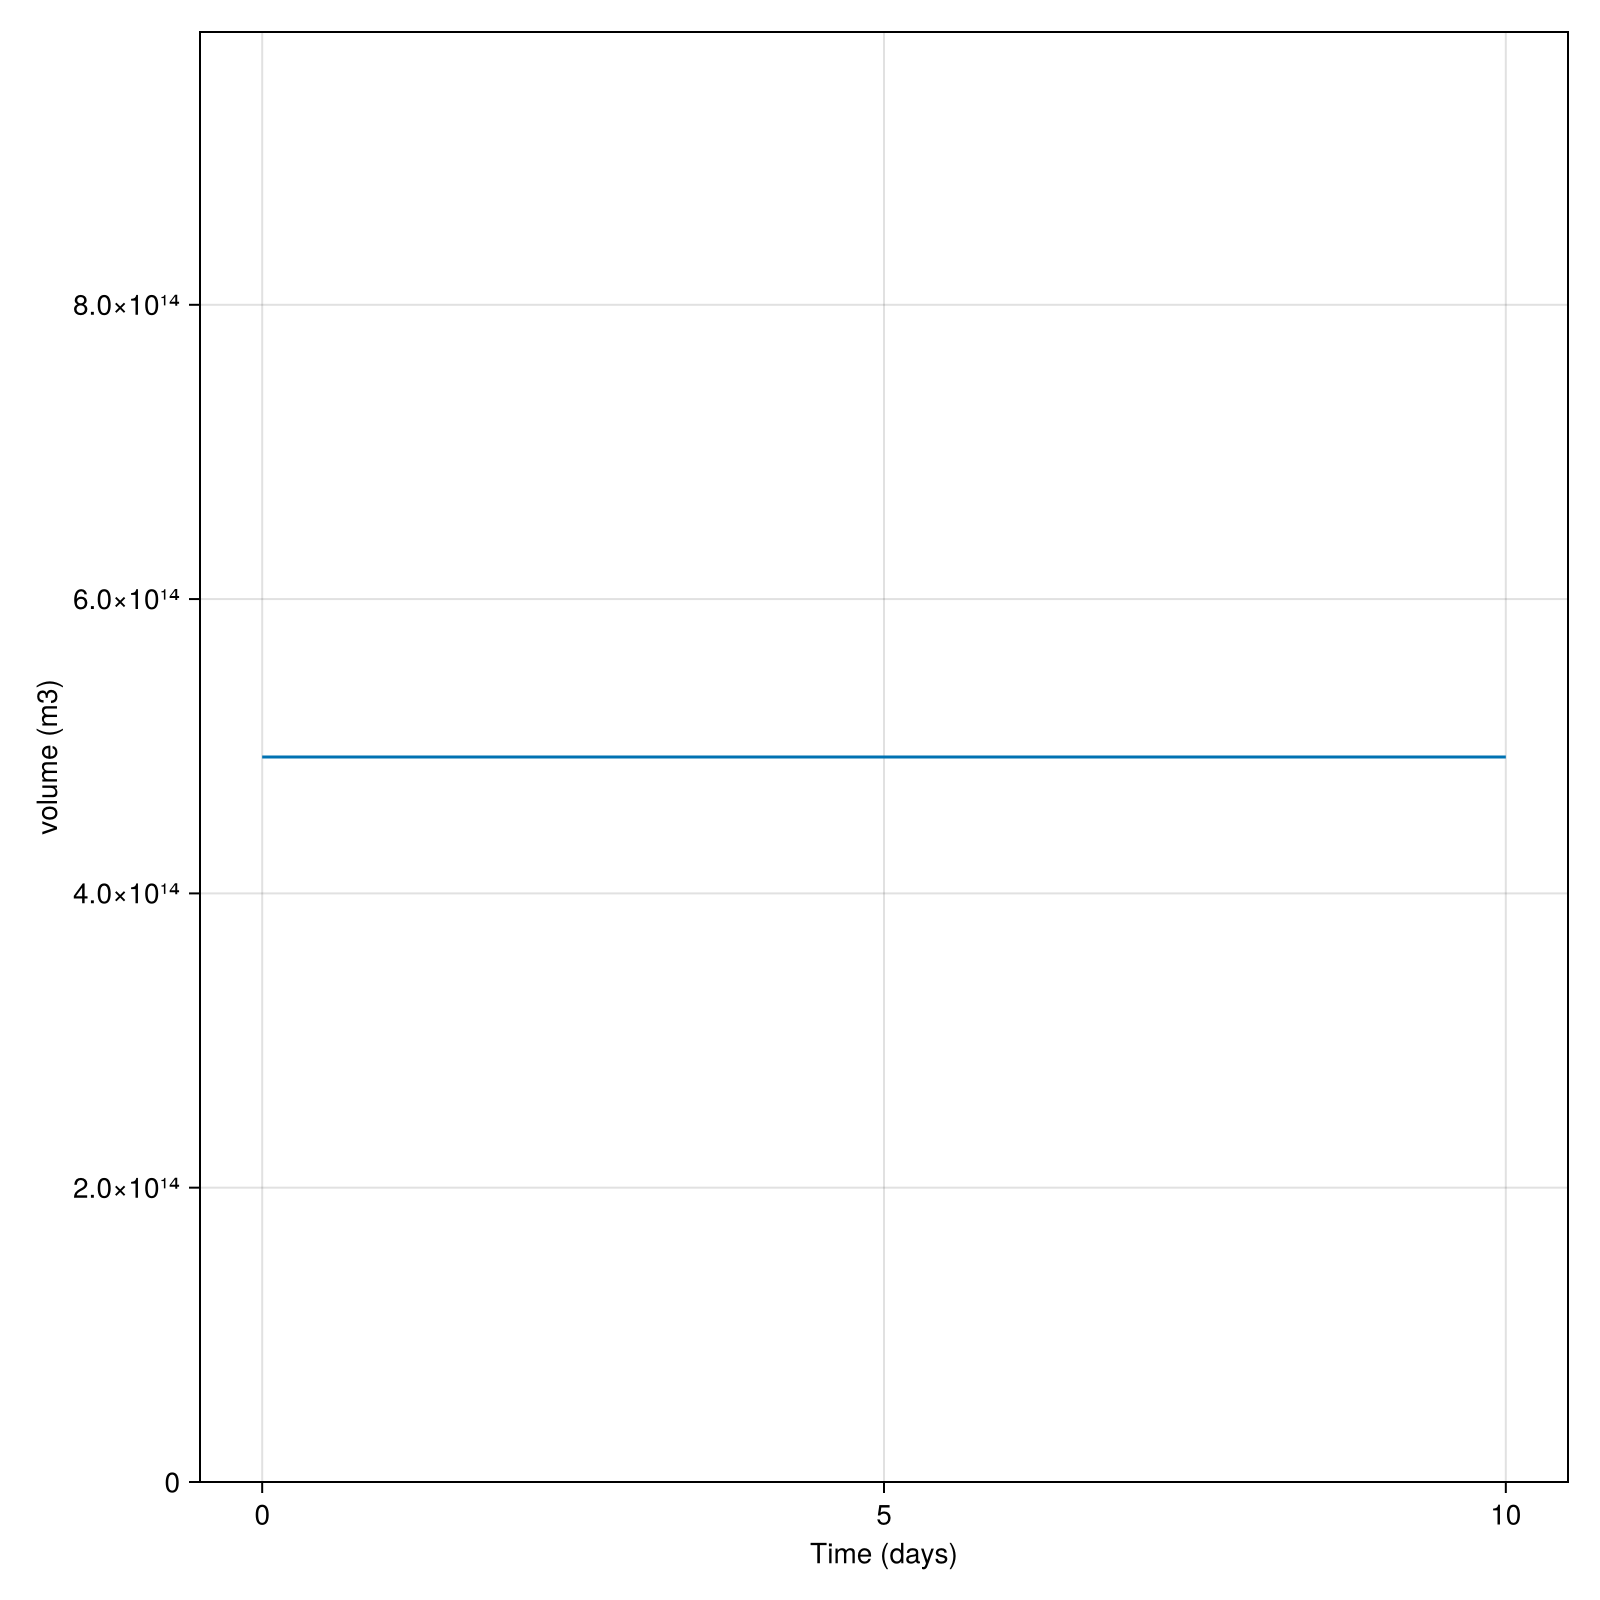

CairoMakie.Screen{IMAGE}


In [ ]:
fig = Figure(size = (800, 800))
axvolint = Axis(fig[1, 1], xlabel="Time (days)", ylabel="volume (m3)")
lines!(axvolint, Vint.times/(3600*24), (view(Vint, 1, 1, 1, :)))

display(fig)


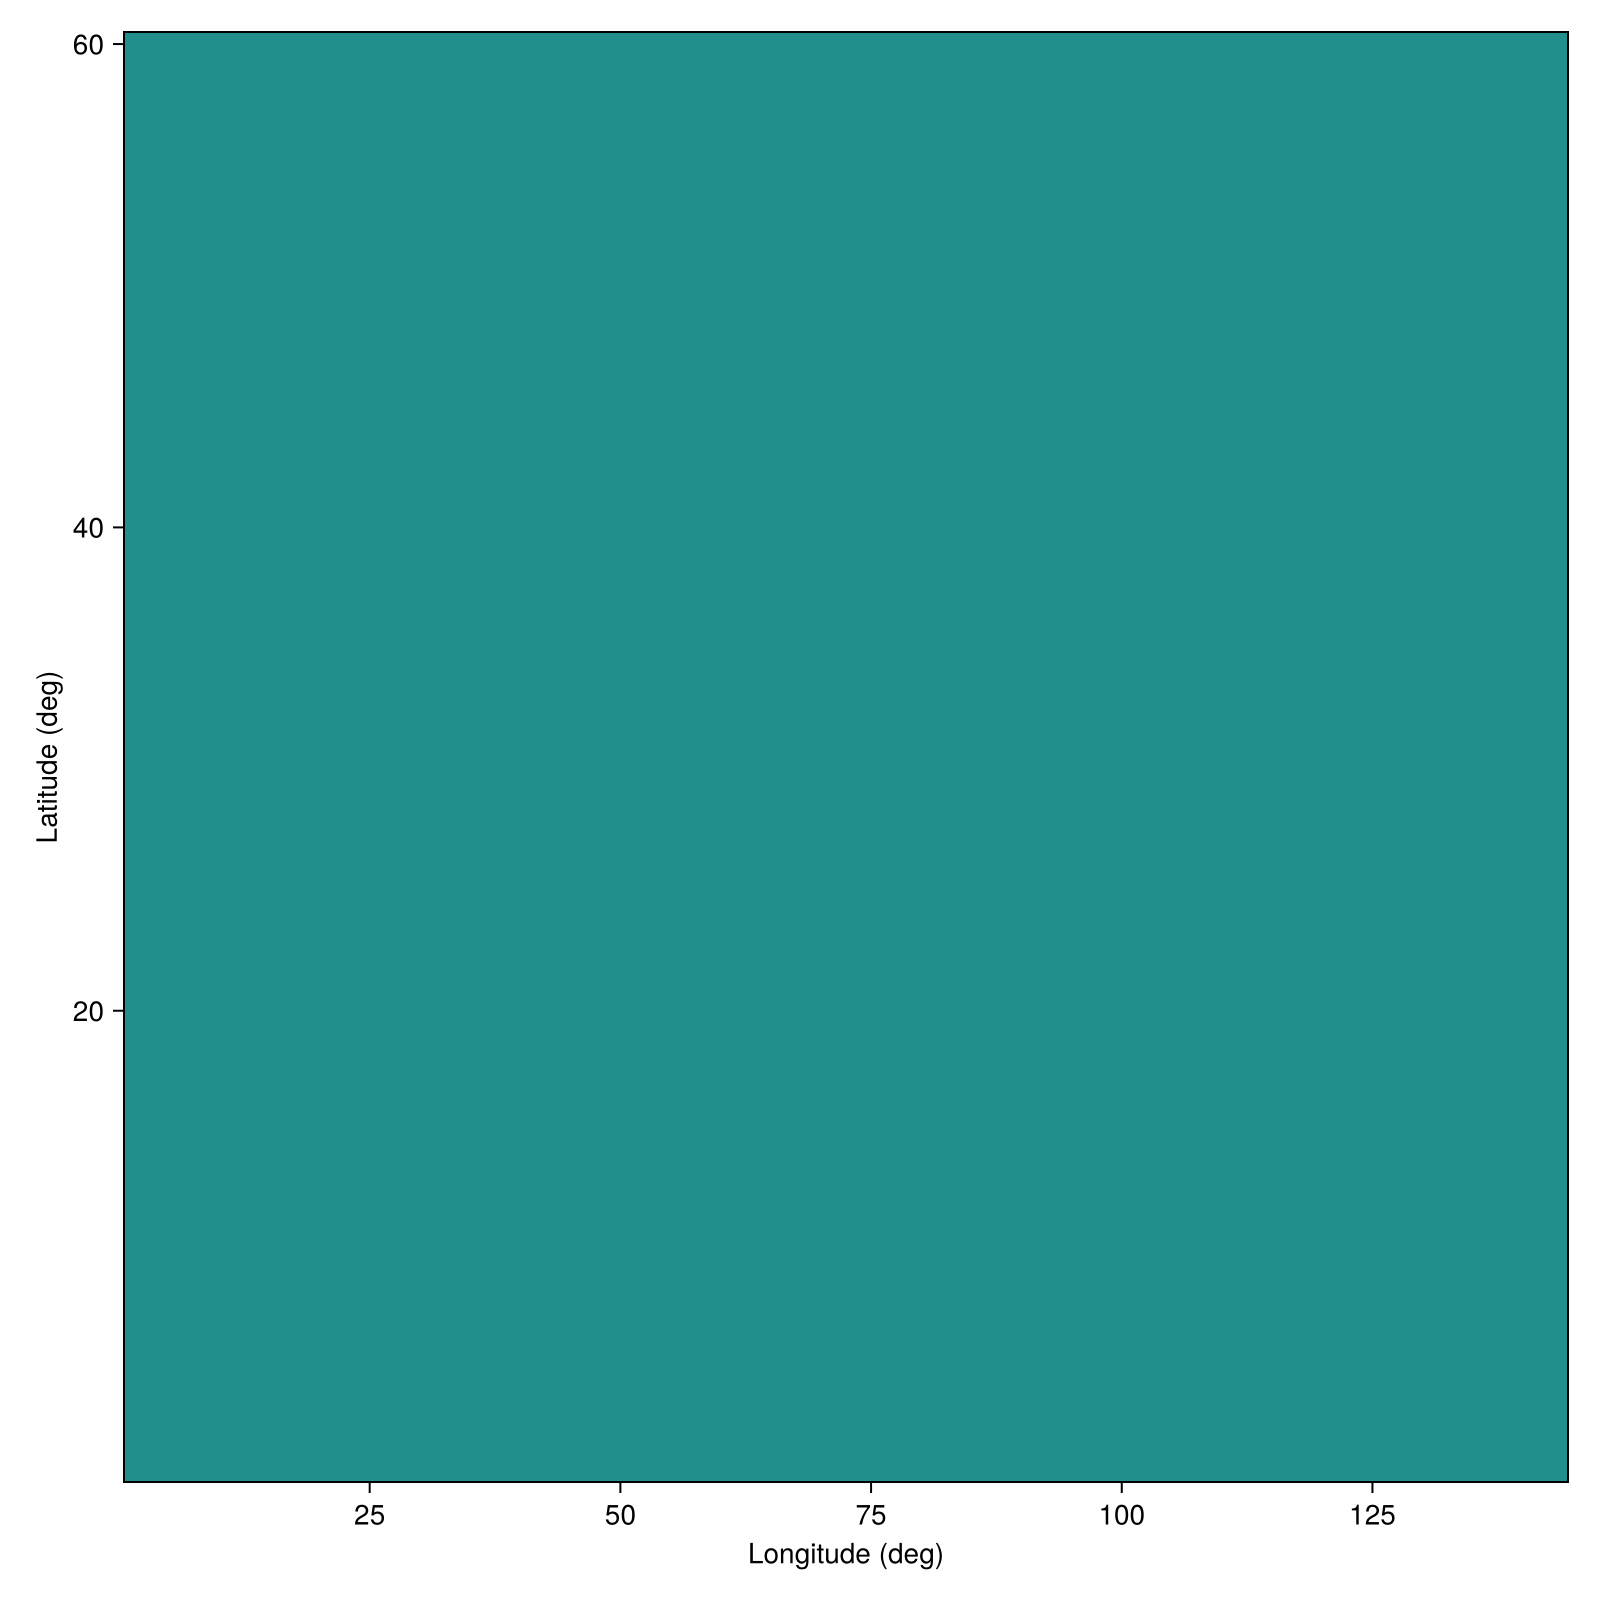

CairoMakie.Screen{IMAGE}


In [ ]:
fig = Figure(size = (800, 800))
axs = Axis(fig[1, 1], xlabel="Longitude (deg)", ylabel="Latitude (deg)")

heatmap!(axs, view(interior(T_surf_1_4_deg[1]), :, :, 1))
display(fig)